In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get results of experiment testing impact of contamination percentage on performance
df = pd.read_json("../reports/contamination.jsonl", lines=True, orient="records")

df["preds"] = df["preds"].apply(np.array)
df["labels"] = df["labels"].apply(np.array)
df["is_anom"] = df["is_anom"].apply(np.array)

df["accuracy"] = df.apply(
    lambda row: (row["preds"] == row["labels"])[~row["is_anom"]].mean() * 100, axis=1
)
parameters = ["dataset", "anomaly_type", "p_anomaly", "len_anomaly"]

dfm = df.groupby(parameters)["accuracy"].agg(["mean", "std"])


idx_cols = ["dataset", "anomaly_type", "len_anomaly"]
dfm = dfm.reset_index()

# All combinations that *should* exist at p_anomaly = 0
expected = dfm[idx_cols].drop_duplicates().assign(p_anomaly=0.0)

# Baseline rows (independent of anomaly_type)
baseline = dfm.query("p_anomaly == 0 and anomaly_type == 'ood_class'")[
    ["dataset", "len_anomaly", "mean", "std"]
]

# Merge baseline values onto all expected rows
fill = expected.merge(baseline, on=["dataset", "len_anomaly"], how="left")

# Combine with original, ensuring no duplicates
dfm = pd.concat([dfm, fill], ignore_index=True).drop_duplicates(
    subset=idx_cols + ["p_anomaly"]
)
dfm = dfm.sort_values(by=idx_cols + ['p_anomaly'])

In [3]:
dfn = dfm.set_index(['dataset', 'anomaly_type', "len_anomaly", "p_anomaly"]).sort_index()
dfn.xs((2), level=('len_anomaly'))

mean       std
dataset        anomaly_type   p_anomaly                     
Covertype      feature_swap   0.00       92.093066  0.103051
                              0.02       91.438604  0.058645
                              0.04       91.043298  0.083329
                              0.08       90.777540  0.179103
               gaussian_noise 0.00       92.093066  0.103051
                              0.02       92.029502  0.117239
                              0.04       92.068746  0.170438
                              0.08       92.087398  0.114509
               label_flip     0.00       92.093066  0.103051
                              0.02       91.438357  0.137370
                              0.04       91.033469  0.172313
                              0.08       90.197767  0.158529
               ood_class      0.00       92.093066  0.103051
                              0.02       92.021158  0.053018
                              0.04       91.974602  0.120789
                              0.08       91.884946  0.115442
               ood_sample     0.00       92.077202  0.100029
                              0.02       91.853141  0.120037
                              0.04       91.759568  0.138258
                              0.08       91.759568  0.101125
Insects abrupt feature_swap   0.00       97.939293  0.039319
                              0.02       97.869259  0.086299
                              0.04       97.718482  0.090239
                              0.08       97.538029  0.087206
               gaussian_noise 0.00       97.939293  0.039319
                              0.02       97.950387  0.046299
                              0.04       97.937870  0.049985
                              0.08       97.866841  0.009981
               label_flip     0.00       97.939293  0.039319
                              0.02       97.613131  0.052641
                              0.04       97.326720  0.089413
                              0.08       96.808929  0.114566
               ood_class      0.00       97.939293  0.039319
                              0.02       97.646004  0.106828
                              0.04       97.369365  0.059969
                              0.08       97.156762  0.155347
               ood_sample     0.00       97.939293  0.039319
                              0.02       97.748463  0.043573
                              0.04       97.648566  0.040348
                              0.08       97.601178  0.052728
Rotated MNIST  feature_swap   0.00       92.280932  0.056841
                              0.02       92.227027  0.093944
                              0.04       92.087539  0.057856
                              0.08       91.967205  0.034015
               gaussian_noise 0.00       92.280932  0.056841
                              0.02       92.168153  0.046281
                              0.04       92.105030  0.033118
                              0.08       92.017076  0.051898
               label_flip     0.00       92.280932  0.056841
                              0.02       91.553807  0.099426
                              0.04       90.752329  0.163402
                              0.08       89.098552  0.066797
               ood_class      0.00       92.280932  0.056841
                              0.02       92.141281  0.029839
                              0.04       92.011136  0.040987
                              0.08       91.755373  0.067026
               ood_sample     0.00       92.280932  0.056841
                              0.02       92.176816  0.053522
                              0.04       92.229553  0.043848
                              0.08       92.119326  0.057875

In [4]:
dfm["anomaly_type"] = dfm["anomaly_type"].replace(
    {
        "ood_class": "OOD Class",
        "ood_sample": "OOD Sample",
        "feature_swap": "Feature Swap",
        "label_flip": "Label Flip",
        "gaussian_noise": "Gaussian Noise",
    }
)

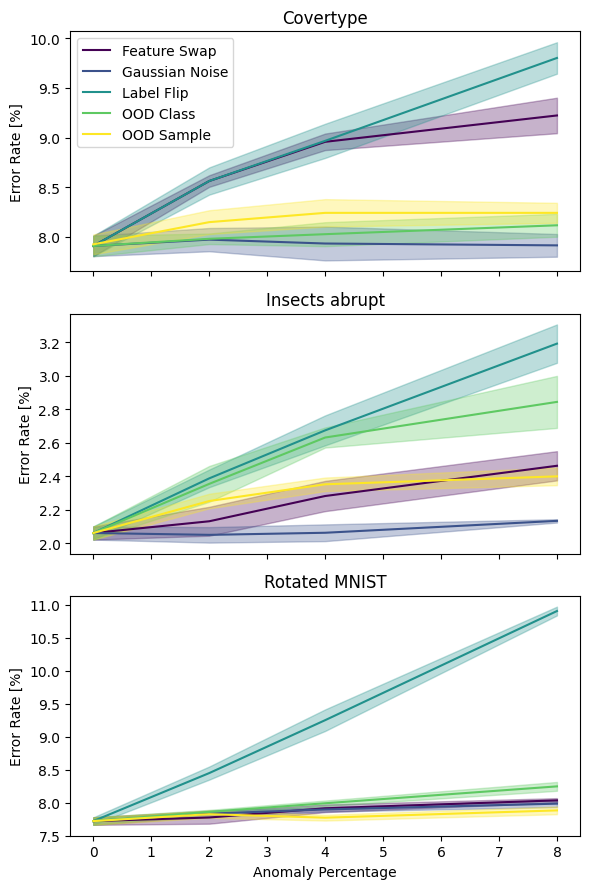

In [5]:
# Plot error rate vs. anomaly percentage for various anomaly types
df_plot = dfm.query("len_anomaly == 2")

row_var = "dataset"
color_var = "anomaly_type"
x_var = "p_anomaly"

nrows = df_plot[row_var].nunique()

# Get unique color labels and assign colors from viridis
color_labels = df_plot[color_var].unique()
cmap = plt.get_cmap("viridis", len(color_labels))
color_map = {label: cmap(i) for i, label in enumerate(color_labels)}

fig, axs = plt.subplots(nrows=nrows, figsize=(6, 3 * nrows), sharex=True, sharey=False)

for ax, (row_label, df_anom_type) in zip(axs, df_plot.groupby(row_var)):
    ax.set_title(row_label)
    for color_label, df_len_anomaly in df_anom_type.groupby(color_var):
        x = df_len_anomaly[x_var] * 100
        mean = 100 - df_len_anomaly["mean"]
        std = df_len_anomaly["std"]
        color = color_map[color_label]
        ax.plot(x, mean, label=color_label, color=color)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3, color=color)
        ax.set_ylabel("Error Rate [%]")

axs[0].legend()

ax.set_xlabel("Anomaly Percentage")


fig.tight_layout()

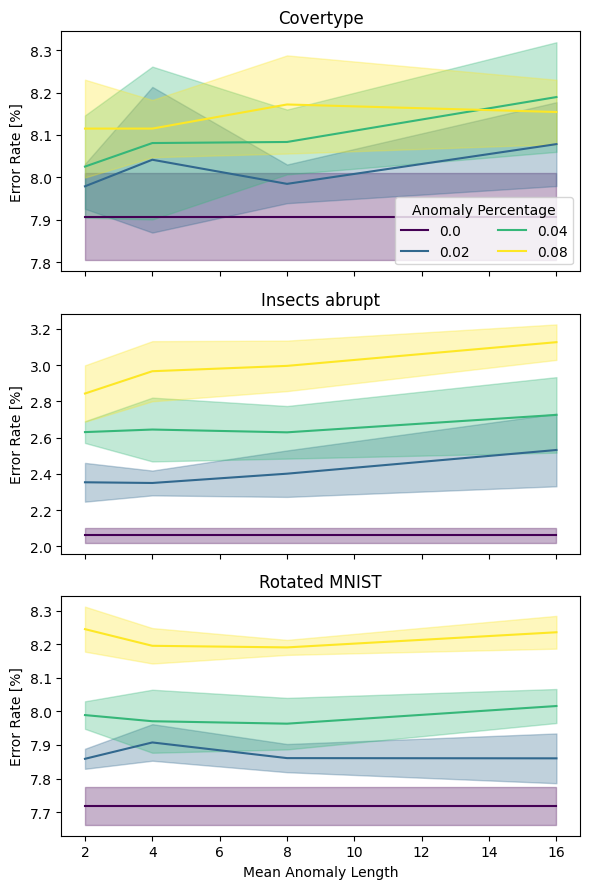

In [6]:
# Plot error rate vs. anomaly length and anomaly percentage for OOD class anomalies
df_plot = dfm.query("anomaly_type == 'OOD Class'")

row_var= 'dataset'
color_var = 'p_anomaly'
x_var = 'len_anomaly'

nrows = df_plot[row_var].nunique()

# Get unique color labels and assign colors from viridis
color_labels = df_plot[color_var].unique()
cmap = plt.get_cmap('viridis', len(color_labels))
color_map = {label: cmap(i) for i, label in enumerate(color_labels)}

fig, axs = plt.subplots(nrows=nrows, figsize=(6, 3*nrows), sharex=True, sharey=False)

for ax, (row_label, df_anom_type) in zip(axs, df_plot.groupby(row_var)):
    ax.set_title(row_label)
    for color_label, df_len_anomaly in df_anom_type.groupby(color_var):
        x = df_len_anomaly[x_var]
        mean = 100 - df_len_anomaly["mean"]
        std = df_len_anomaly["std"]
        color = color_map[color_label]
        ax.plot(x, mean, label=color_label, color=color)
        ax.fill_between(x, mean-std, mean+std, alpha=.3, color=color)
        ax.set_ylabel("Error Rate [%]")

axs[0].legend(title='Anomaly Percentage', ncols=2)
ax.set_xlabel("Mean Anomaly Length")
fig.tight_layout()

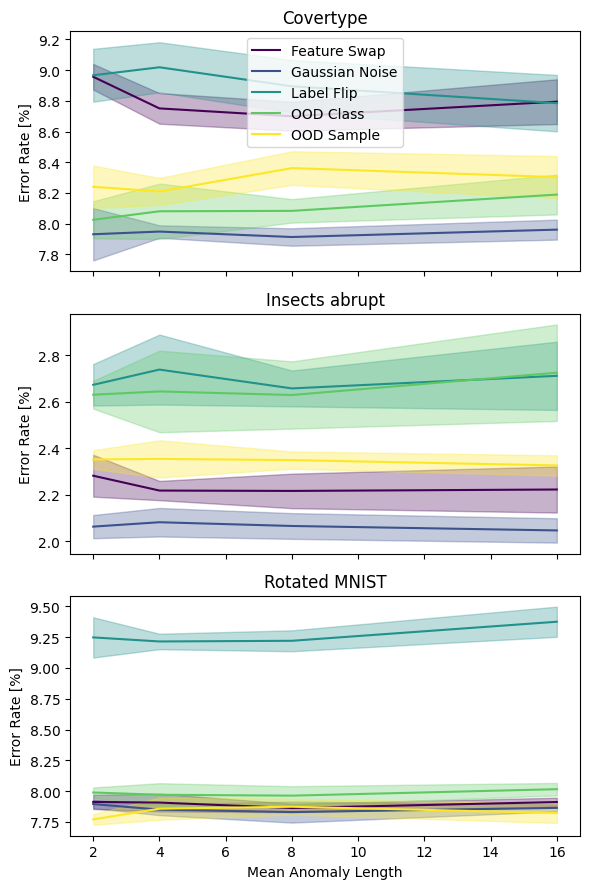

In [7]:
# Plot error rate vs. anomaly percentage for various anonomaly types
df_plot = dfm.query("p_anomaly == 0.04")

row_var= 'dataset'
color_var = 'anomaly_type'
x_var = 'len_anomaly'

nrows = df_plot[row_var].nunique()

# Get unique color labels and assign colors from viridis
color_labels = df_plot[color_var].unique()
cmap = plt.get_cmap('viridis', len(color_labels))
color_map = {label: cmap(i) for i, label in enumerate(color_labels)}

fig, axs = plt.subplots(nrows=nrows, figsize=(6, 3*nrows), sharex=True, sharey=False)

for ax, (row_label, df_anom_type) in zip(axs, df_plot.groupby(row_var)):
    ax.set_title(row_label)
    for color_label, df_len_anomaly in df_anom_type.groupby(color_var):
        x = df_len_anomaly[x_var]
        mean = 100 - df_len_anomaly["mean"]
        std = df_len_anomaly["std"]
        color = color_map[color_label]
        ax.plot(x, mean, label=color_label, color=color)
        ax.fill_between(x, mean-std, mean+std, alpha=.3, color=color)
        ax.set_ylabel("Error Rate [%]")

axs[0].legend()
axs[-1].set_xlabel('Mean Anomaly Length')
fig.tight_layout()

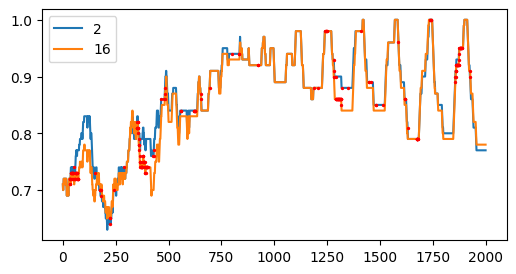

In [9]:
df_plot = df.query(
    "dataset == 'Covertype' and p_anomaly == 0.04 and anomaly_type == 'feature_swap' and seed == 0"
)
df_plot = df_plot[df_plot["len_anomaly"].isin([2, 16])]
excerpt = [2000, 4000]

color_var = "len_anomaly"
row_var = "anomaly_type"

nrows = df_plot[row_var].nunique()

fig, ax = plt.subplots(nrows=nrows, figsize=(6, 3 * nrows))

for row_label, df_row in df_plot.groupby(row_var):
    for color_label, df_color in df_row.groupby(color_var):
        rolling_accuracy = df_color.apply(
            lambda x: pd.Series(x["preds"] == x["labels"])
            .rolling(window=100, min_periods=1)
            .mean(),
            axis=1,
        ).values[0]
        rolling_accuracy = rolling_accuracy[excerpt[0] : excerpt[1]]

        ax.plot(rolling_accuracy, label=color_label)

        # Highlight anomalies
        is_anom = df_color["is_anom"].item()
        x = np.arange(2000)
        x_anom = x[is_anom[2000:4000]]

        ax.scatter(
            x_anom,
            rolling_accuracy[x_anom],
            color="red",
            zorder=5,
            s=2,
        )

ax.legend()